# Optimization of Dissipative Qubit Reset

In [1]:
pip install krotov


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# NBVAL_IGNORE_OUTPUT
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import math

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{int}[0]{\text{int}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

This example illustrates an optimization in an *open* quantum system,
where the dynamics is governed by the Liouville-von Neumann equation. Hence,
states are represented by density matrices $\op{\rho}(t)$ and the time-evolution
operator is given by a general dynamical map $\DynMap$.

## Define parameters

The system consists of a qubit with Hamiltonian
$\op{H}_{q}(t) = - \frac{\omega_{q}}{2} \op{\sigma}_{z} - \frac{\epsilon(t)}{2} \op{\sigma}_{z}$,
where $\omega_{q}$ is an energy level splitting that can be dynamically adjusted
by the control $\epsilon(t)$. This qubit couples strongly to another two-level
system (TLS) with Hamiltonian $\op{H}_{t} = - \frac{\omega_{t}}{2} \op{\sigma}_{z}$ with
static energy level splitting $\omega_{t}$. The coupling strength between both
systems is given by $J$ with the interaction Hamiltonian given by $\op{H}_{\int}
= J \op{\sigma}_{x} \otimes \op{\sigma}_{x}$.

The Hamiltonian for the system of qubit and TLS is

$$
  \op{H}(t)
    = \op{H}_{q}(t) \otimes \identity_{t}
      + \identity_{q} \otimes \op{H}_{t} + \op{H}_{\int}.
$$

In addition, the TLS is embedded in a heat bath with inverse temperature
$\beta$. The TLS couples to the bath with rate $\kappa$. In order to simulate
the dissipation arising from this coupling, we consider the two Lindblad
operators

$$
\begin{split}
\op{L}_{1} &= \sqrt{\kappa (N_{th}+1)} \identity_{q} \otimes \ket{0}\bra{1} \\
\op{L}_{2} &= \sqrt{\kappa N_{th}} \identity_{q} \otimes \ket{1}\bra{0}
\end{split}
$$

with $N_{th} = 1/(e^{\beta \omega_{t}} - 1)$.

In [3]:
omega = 1  # qubit level splitting
g = 0.2*omega  # qubit-TLS coupling
gamma = 0.05*omega  # TLS decay rate
N=0 # inverse bath temperature
T = 15 # final time
nt = 1000  # number of time steps

## Define the Liouvillian

The dynamics of the qubit-TLS system state $\op{\rho}(t)$ is governed by the
Liouville-von Neumann equation

$$
\begin{split}
  \frac{\partial}{\partial t} \op{\rho}(t)
    &= \Liouville(t) \op{\rho}(t) \\
    &= - i \left[\op{H}(t), \op{\rho}(t)\right]
      + \sum_{k=1,2} \left(
            \op{L}_{k} \op{\rho}(t) \op{L}_{k}^\dagger
            - \frac{1}{2}
            \op{L}_{k}^\dagger
            \op{L}_{k} \op{\rho}(t)
            - \frac{1}{2} \op{\rho}(t)
            \op{L}_{k}^\dagger
            \op{L}_{k}
        \right)\,.
\end{split}
$$

In [4]:
def liouvillian(omega, g, gamma, N):
    """Liouvillian for the coupled system of qubit and TLS"""

    H0_q = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # drive qubit Hamiltonian
    H1_q = -0.2*qutip.operators.sigmax()

    # drift TLS Hamiltonian
    H0_T = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))

    # Lift Hamiltonians to joint system operators
    H0 = qutip.tensor(H0_q, qutip.qeye(2)) + qutip.tensor(qutip.qeye(2), H0_T)
    H1 = qutip.tensor(H1_q, qutip.qeye(2))

    # qubit-TLS interaction
    H_int =  g*(qutip.tensor(qutip.Qobj(np.array([[0, 0], [1, 0]])),qutip.Qobj(np.array([[0, 1], [0, 0]])))+qutip.tensor(qutip.Qobj(np.array([[0, 1], [0, 0]])),qutip.Qobj(np.array([[0, 0], [1, 0]]))))

    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0 + H_int)
    H1 = qutip.Qobj(H1)

    # Define Lindblad operators
    # Cooling on TLS
    L1 = np.sqrt(gamma * (N + 1)) * qutip.tensor(qutip.Qobj(np.array([[0, 1], [0, 0]])),qutip.qeye(2))
    # Heating on TLS
    L2 = np.sqrt(gamma * N) * qutip.tensor(qutip.Qobj([[0, 0], [1, 0]]),qutip.qeye(2))
    

    # convert Lindblad operators to QuTiP objects
    L1 = qutip.Qobj(L1)
    L2 = qutip.Qobj(L2)

    # generate the Liouvillian
    L0 = qutip.liouvillian(H=H0, c_ops=[L1, L2])
    L1 = qutip.liouvillian(H=H1)

    # Shift the qubit and TLS into resonance by default
    eps0 = lambda t, args: 0.000000000001
    return [L0, [L1, eps0]], H1


L, H1 = liouvillian(omega, g, gamma, N)


## Define the optimization target

The initial state of qubit and TLS are assumed to be in thermal equilibrium with
the heat bath (although only the TLS is directly interacting with the bath).
Both states are given by

$$
  \op{\rho}_{\alpha}^{th} =
\frac{e^{x_{\alpha}} \ket{0}\bra{0} + e^{-x_{\alpha}} \ket{1}\bra{1}}{2
\cosh(x_{\alpha})},
  \qquad
  x_{\alpha} = \frac{\omega_{\alpha} \beta}{2},
$$

with $\alpha = q,t$. The initial state of the bipartite system
of qubit and TLS is given by the thermal state
$\op{\rho}_{th} = \op{\rho}_{q}^{th} \otimes \op{\rho}_{t}^{th}$.

In [5]:
rho_th = qutip.Qobj(qutip.tensor(qutip.Qobj(np.diag([1,0])), qutip.Qobj(np.diag([1,0]))))

Since we are ultimately only interested in the state of the qubit, we define
`trace_A`. It returns the reduced state of the qubit
$\op{\rho}_{q} = \tr_{t}\{\op{\rho}\}$ when passed
the state $\op{\rho}$ of the bipartite system.

In [6]:
def trace_A(rho):
    """Partial trace over the A degrees of freedom"""
    rho_q = np.zeros(shape=(2, 2), dtype=np.complex_)
    rho_q[0, 0] = rho[0, 0] + rho[2, 2]
    rho_q[0, 1] = rho[0, 1] + rho[2, 3]
    rho_q[1, 0] = rho[1, 0] + rho[3, 2]
    rho_q[1, 1] = rho[1, 1] + rho[3, 3]
    return qutip.Qobj(rho_q)

The target state is (temporarily) the ground state of the bipartite system,
i.e., $\op{\rho}_{\tgt} = \ket{00}\bra{00}$. Note that in the end we will only
optimize the reduced state of the qubit.

In [7]:
rho_q_trg = qutip.Qobj(np.diag([1, 0]))
rho_T_trg = qutip.Qobj(np.diag([0, 1]))
rho_trg = qutip.tensor(rho_q_trg, rho_T_trg)
rho_trg = qutip.Qobj(rho_trg)

Next, the list of `objectives` is defined, which contains the initial and target
state and the Liouvillian $\Liouville(t)$ that determines the system dynamics.

In [8]:
objectives = [krotov.Objective(initial_state=rho_th, target=rho_trg, H=L)]

In the following, we define the shape function $S(t)$, which we use in order to
ensure a smooth switch on and off in the beginning and end. Note that at times
$t$ where $S(t)$ vanishes, the updates of the field is suppressed.

In [9]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=0.005 * T, t_fall=0.005 * T, func='sinsq'
    )

We re-use this function to also shape the guess control $\epsilon_{0}(t)$ to be
zero at $t=0$ and $t=T$. This is on top of the originally defined constant
value shifting the qubit and TLS into resonance.

In [10]:
def shape_field(eps0):
    """Applies the shape function S(t) to the guess field"""
    eps0_shaped = lambda t, args: eps0(t, args) * S(t)
    return eps0_shaped


L[1][1] = shape_field(L[1][1])

At last, before heading to the actual optimization below, we assign the shape
function $S(t)$ to the OCT parameters of the control and choose `lambda_a`, a
numerical parameter that controls the field update magnitude in each iteration.

In [11]:
pulse_options = {L[1][1]: dict(lambda_a=1, update_shape=S)}

## Simulate the dynamics of the guess field


In [12]:
tlist = np.linspace(0, T, nt)

In [13]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

The following plot shows the guess field $\epsilon_{0}(t)$ as a constant that
puts qubit and TLS into resonance, but with a smooth switch-on and switch-off.

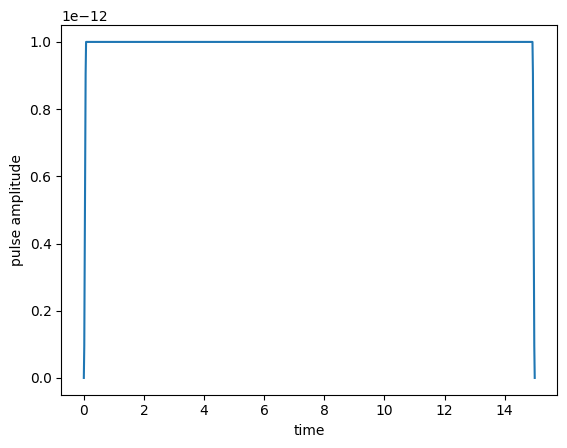

In [14]:
plot_pulse(L[1][1], tlist)

We solve the equation of motion for this guess field, storing the expectation
values for the population in the bipartite levels:


In [18]:
psi00 = qutip.Qobj(np.kron(np.array([1,0]), np.array([1,0])))
psi01 = qutip.Qobj(np.kron(np.array([1,0]), np.array([0,1])))
psi10 = qutip.Qobj(np.kron(np.array([0,1]), np.array([1,0])))
psi11 = qutip.Qobj(np.kron(np.array([0,1]), np.array([0,1])))
proj_00 = qutip.ket2dm(psi00)
proj_01 = qutip.ket2dm(psi01)
proj_10 = qutip.ket2dm(psi10)
proj_11 = qutip.ket2dm(psi11)

In [19]:
guess_dynamics = objectives[0].mesolve(
    tlist, e_ops=[proj_00, proj_01,proj_10,proj_11]
)

TypeError: e_ops dims ([[4], [4]]) are not compatible with the state's ([[2, 2], [2, 2]])

In [17]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(
        result.times,
        np.array(result.expect[0]),
        label='00',
    )
    ax.plot(
        result.times,
        np.array(result.expect[1]),
        label='01',
    )
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)


plot_population(guess_dynamics)


NameError: name 'guess_dynamics' is not defined

The population dynamics of qubit and TLS ground state show that
both are oscillating and especially the qubit's ground state population reaches
a maximal value at intermediate times $t < T$. This maximum is indeed the
maximum that is physically possible. It corresponds to a perfect swap of
the initial qubit and TLS purities. However, we want to reach this maximum at
final time $T$ (not before), so the guess control is not yet working as desired.

## Optimize

Our optimization target is the ground state $\ket{\Psi_{q}^{\tgt}}
= \ket{0}$ of the qubit, irrespective of the state of the TLS. Thus, our
optimization functional reads

$$
  J_T = 1 -
\Braket{\Psi_{q}^{\tgt}}{\tr_{t}\{\op{\rho}(T)\} \,|\; \Psi_{q}^{\tgt}}\,,
$$

and we first define `print_qubit_error`, which prints out the
above functional after each iteration.


In [20]:
def print_qubit_error(**args):
    """Utility function writing the qubit error to screen"""
    taus = []
    for state_T in args['fw_states_T']:
        state_q_T = trace_A(state_T)
        taus.append(state_q_T[1, 1].real)
    J_T = 1 - np.average(taus)
    print("    qubit error: %.1e" % J_T)
    return J_T

In order to minimize the above functional, we need to provide the correct
`chi_constructor` for the Krotov optimization. This is the only place where the
functional (implicitly) enters the optimization.
Given our bipartite system and choice of $J_T$, the equation for
$\op{\chi}(T)$ reads

$$
  \op{\chi}(T)
  =
  \frac{1}{2} \ket{\Psi_{q}^{\tgt}} \bra{\Psi_{q}^{\tgt}} \otimes \op{1}_{2}
  =
  \frac{1}{2} \ket{00}\bra{00} + \frac{1}{2} \ket{01}\bra{01}.
$$

In [21]:
def chis_qubit(fw_states_T, objectives, tau_vals):
    """Calculate chis for the chosen functional"""
    chis = []
    for state_i_T in fw_states_T:
        chi_i = qutip.Qobj(qutip.tensor(qutip.Qobj(np.diag([1, 1])),rho_T_trg))
        chis.append(chi_i)
    return chis

We now carry out the optimization for five iterations.

In [22]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    
    H0_q = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # drive qubit Hamiltonian
    H1_q = -0.2*qutip.operators.sigmax()

    # drift TLS Hamiltonian
    H0_T = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))

    # Lift Hamiltonians to joint system operators
    H0 = qutip.tensor(H0_q, qutip.qeye(2)) + qutip.tensor(qutip.qeye(2), H0_T)
    H1 = qutip.tensor(H1_q, qutip.qeye(2))

    # qubit-TLS interaction
    H_int =  g*(qutip.tensor(qutip.Qobj(np.array([[0, 0], [1, 0]])),qutip.Qobj(np.array([[0, 1], [0, 0]])))+qutip.tensor(qutip.Qobj(np.array([[0, 1], [0, 0]])),qutip.Qobj(np.array([[0, 0], [1, 0]]))))

    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0 + H_int)
    H1 = qutip.Qobj(H1)
    
    optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
      tlist, e_ops=[]
    )
    fig, [ax_ctr,ax,ay] = plt.subplots(nrows=3, figsize=(4, 5))
    n_iters = len(opt_result.iters)
    EEnergy=np.zeros(nt)
    W=np.zeros(nt)
    Q=np.zeros(nt)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
    EField=np.transpose(np.array(opt_result.optimized_controls))
    EEnergy[0]=(np.square(EField[0]))*(T/nt)
    W[0]=np.real((EField[1]-EField[0])*np.trace(np.array(H1*optimized_dynamics.states[0])))
    Q[0]=np.real(np.trace(np.array((H0+H1*qutip.Qobj(EField[0]))*(optimized_dynamics.states[1]-optimized_dynamics.states[0]))))
    a=0
    b=0
    c=0
    print(qutip.Qobj(EField[0]))
    for i in range (1,nt):
      a+=np.square(EField[i-1])
      b+=np.real((EField[i]-EField[i-1])*np.trace(np.array(H1*optimized_dynamics.states[i-1])))
      c+=np.real(np.trace(np.array((H0+H1*qutip.Qobj(EField[i-1]))*(optimized_dynamics.states[i]-optimized_dynamics.states[i-1]))))
      EEnergy[i]=(np.square(EField[i])+a)*(T/nt)
      if i==nt-1:
        W[i]= np.real((EField[i]-EField[i-1])*np.trace(np.array(H1*optimized_dynamics.states[i])))+b
        Q[i]=np.real(np.trace(np.array((H0+H1*qutip.Qobj(EField[i]))*(optimized_dynamics.states[i]-optimized_dynamics.states[i-1]))))+c
      else:
        W[i]= np.real((EField[i+1]-EField[i])*np.trace(np.array(H1*optimized_dynamics.states[i])))+b
        Q[i]=np.real(np.trace(np.array((H0+H1*qutip.Qobj(EField[i]))*(optimized_dynamics.states[i+1]-optimized_dynamics.states[i]))))+c
      
    
    ay.plot(tlist,np.transpose(EEnergy-W))
    ay.set_title('Difference')
    ax.plot(tlist,np.transpose(EEnergy))
    ax.set_title('Energy of the field')
    plt.legend()
    fig3, az =plt.subplots()
    az.plot(tlist,np.transpose(Q))
    az.set_title("Heat")
    plt.show(fig)
    plt.show(fig3)

Iteration 0
    objectives:
        1:ρ₀[2⊗2,2⊗2] to ρ₁[2⊗2,2⊗2] via [𝓛₀[[2⊗2,2⊗2],[2⊗2,2⊗2]], [𝓛₁[[2⊗2,2⊗2],[2⊗2,2⊗2]], u₁(t)]]
    adjoint objectives:
        1:ρ₂[2⊗2,2⊗2] to ρ₃[2⊗2,2⊗2] via [𝓛₂[[2⊗2,2⊗2],[2⊗2,2⊗2]], [𝓛₃[[2⊗2,2⊗2],[2⊗2,2⊗2]], u₁(t)]]
    chi_constructor: chis_qubit
    mu: derivative_wrt_pulse
    S(t) (ranges): [0.000000, 1.000000]
    iter_start: 0
    iter_stop: 20000
    duration: 0.2 secs (started at 2023-01-19 20:32:36)
    optimized pulses (ranges): [0.00, 0.00]
    ∫gₐ(t)dt: 0.00e+00
    λₐ: 1.00e+00
    storage (bw, fw, fw0): None, None, None
    fw_states_T norm: 1.000000
    τ: (0.00e+00:0.00π)
    qubit error: 1.0e+00
Iteration 1
    duration: 0.9 secs (started at 2023-01-19 20:32:36)
    optimized pulses (ranges): [-0.00, 0.00]
    ∫gₐ(t)dt: 3.16e-21
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (0.00e+00:0.00π)
    qubit error: 1.0e+00
Iteration 2
    duration: 0.9 secs (start

Iteration 26
    duration: 0.9 secs (started at 2023-01-19 20:33:00)
    optimized pulses (ranges): [-0.00, 0.00]
    ∫gₐ(t)dt: 1.74e-18
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (0.00e+00:0.00π)
    qubit error: 1.0e+00
Iteration 27
    duration: 1.0 secs (started at 2023-01-19 20:33:01)
    optimized pulses (ranges): [-0.00, 0.00]
    ∫gₐ(t)dt: 2.61e-18
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (0.00e+00:0.00π)
    qubit error: 1.0e+00
Iteration 28
    duration: 1.0 secs (started at 2023-01-19 20:33:02)
    optimized pulses (ranges): [-0.00, 0.00]
    ∫gₐ(t)dt: 3.14e-18
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (0.00e+00:0.00π)
    qubit error: 1.0e+00
Iteration 29
    duration: 1.0 secs (started at 2023-01-19 20:33:03)
    optimized pulses (ran

    qubit error: 1.0e+00
Iteration 54
    duration: 1.0 secs (started at 2023-01-19 20:33:28)
    optimized pulses (ranges): [-0.00, 0.00]
    ∫gₐ(t)dt: 7.70e-13
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.98e-12:0.00π)
    qubit error: 1.0e+00
Iteration 55
    duration: 0.9 secs (started at 2023-01-19 20:33:29)
    optimized pulses (ranges): [-0.00, 0.00]
    ∫gₐ(t)dt: 1.28e-12
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.30e-12:0.00π)
    qubit error: 1.0e+00
Iteration 56
    duration: 1.0 secs (started at 2023-01-19 20:33:30)
    optimized pulses (ranges): [-0.00, 0.00]
    ∫gₐ(t)dt: 2.15e-12
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.55e-12:0.00π)
    qubit error: 1.0e+00
Iteration 57
    duration: 0.9 secs (started at 2023-01-19 20:33:31)


    qubit error: 1.0e+00
Iteration 82
    duration: 1.1 secs (started at 2023-01-19 20:33:57)
    optimized pulses (ranges): [-0.00, 0.00]
    ∫gₐ(t)dt: 1.51e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.73e-06:0.00π)
    qubit error: 1.0e+00
Iteration 83
    duration: 1.1 secs (started at 2023-01-19 20:33:58)
    optimized pulses (ranges): [-0.00, 0.00]
    ∫gₐ(t)dt: 2.53e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (6.27e-06:0.00π)
    qubit error: 1.0e+00
Iteration 84
    duration: 1.3 secs (started at 2023-01-19 20:33:59)
    optimized pulses (ranges): [-0.00, 0.00]
    ∫gₐ(t)dt: 4.26e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.05e-05:0.00π)
    qubit error: 1.0e+00
Iteration 85
    duration: 1.3 secs (started at 2023-01-19 20:34:01)


    qubit error: 2.8e-01
Iteration 110
    duration: 1.8 secs (started at 2023-01-19 20:34:34)
    optimized pulses (ranges): [-1.63, 1.41]
    ∫gₐ(t)dt: 5.42e-02
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.42e-01:0.00π)
    qubit error: 2.3e-01
Iteration 111
    duration: 1.9 secs (started at 2023-01-19 20:34:36)
    optimized pulses (ranges): [-1.73, 1.50]
    ∫gₐ(t)dt: 3.85e-02
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.40e-01:0.00π)
    qubit error: 1.9e-01
Iteration 112
    duration: 2.0 secs (started at 2023-01-19 20:34:38)
    optimized pulses (ranges): [-1.81, 1.57]
    ∫gₐ(t)dt: 2.67e-02
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.31e-01:0.00π)
    qubit error: 1.6e-01
Iteration 113
    duration: 2.0 secs (started at 2023-01-19 20:34:

Iteration 137
    duration: 1.4 secs (started at 2023-01-19 20:35:19)
    optimized pulses (ranges): [-2.12, 1.90]
    ∫gₐ(t)dt: 2.55e-04
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.78e-01:0.00π)
    qubit error: 1.0e-01
Iteration 138
    duration: 1.3 secs (started at 2023-01-19 20:35:20)
    optimized pulses (ranges): [-2.12, 1.90]
    ∫gₐ(t)dt: 2.46e-04
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.75e-01:0.00π)
    qubit error: 9.9e-02
Iteration 139
    duration: 1.4 secs (started at 2023-01-19 20:35:22)
    optimized pulses (ranges): [-2.11, 1.90]
    ∫gₐ(t)dt: 2.37e-04
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.73e-01:0.00π)
    qubit error: 9.9e-02
Iteration 140
    duration: 1.4 secs (started at 2023-01-19 20:35:23)
    optimized pulses 

    qubit error: 9.5e-02
Iteration 165
    duration: 1.4 secs (started at 2023-01-19 20:35:59)
    optimized pulses (ranges): [-2.04, 1.88]
    ∫gₐ(t)dt: 1.26e-04
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.22e-01:0.00π)
    qubit error: 9.5e-02
Iteration 166
    duration: 1.6 secs (started at 2023-01-19 20:36:00)
    optimized pulses (ranges): [-2.04, 1.89]
    ∫gₐ(t)dt: 1.23e-04
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.21e-01:0.00π)
    qubit error: 9.5e-02
Iteration 167
    duration: 1.5 secs (started at 2023-01-19 20:36:02)
    optimized pulses (ranges): [-2.04, 1.89]
    ∫gₐ(t)dt: 1.21e-04
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.19e-01:0.00π)
    qubit error: 9.4e-02
Iteration 168
    duration: 1.5 secs (started at 2023-01-19 20:36:

Iteration 192
    duration: 1.5 secs (started at 2023-01-19 20:36:40)
    optimized pulses (ranges): [-1.98, 1.96]
    ∫gₐ(t)dt: 8.53e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.84e-01:0.00π)
    qubit error: 9.2e-02
Iteration 193
    duration: 1.3 secs (started at 2023-01-19 20:36:41)
    optimized pulses (ranges): [-1.98, 1.96]
    ∫gₐ(t)dt: 8.42e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.82e-01:0.00π)
    qubit error: 9.2e-02
Iteration 194
    duration: 1.5 secs (started at 2023-01-19 20:36:43)
    optimized pulses (ranges): [-1.98, 1.96]
    ∫gₐ(t)dt: 8.34e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.81e-01:0.00π)
    qubit error: 9.2e-02
Iteration 195
    duration: 1.7 secs (started at 2023-01-19 20:36:44)
    optimized pulses 

    qubit error: 9.0e-02
Iteration 220
    duration: 1.4 secs (started at 2023-01-19 20:37:21)
    optimized pulses (ranges): [-1.93, 2.02]
    ∫gₐ(t)dt: 6.34e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.54e-01:0.00π)
    qubit error: 9.0e-02
Iteration 221
    duration: 1.4 secs (started at 2023-01-19 20:37:22)
    optimized pulses (ranges): [-1.93, 2.02]
    ∫gₐ(t)dt: 6.23e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.53e-01:0.00π)
    qubit error: 9.0e-02
Iteration 222
    duration: 1.3 secs (started at 2023-01-19 20:37:24)
    optimized pulses (ranges): [-1.92, 2.02]
    ∫gₐ(t)dt: 6.19e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.52e-01:0.00π)
    qubit error: 9.0e-02
Iteration 223
    duration: 1.2 secs (started at 2023-01-19 20:37:

Iteration 247
    duration: 1.5 secs (started at 2023-01-19 20:38:00)
    optimized pulses (ranges): [-1.89, 2.06]
    ∫gₐ(t)dt: 4.89e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.32e-01:0.00π)
    qubit error: 8.8e-02
Iteration 248
    duration: 1.5 secs (started at 2023-01-19 20:38:01)
    optimized pulses (ranges): [-1.89, 2.06]
    ∫gₐ(t)dt: 4.87e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.31e-01:0.00π)
    qubit error: 8.8e-02
Iteration 249
    duration: 1.5 secs (started at 2023-01-19 20:38:03)
    optimized pulses (ranges): [-1.89, 2.06]
    ∫gₐ(t)dt: 4.81e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.30e-01:0.00π)
    qubit error: 8.8e-02
Iteration 250
    duration: 1.6 secs (started at 2023-01-19 20:38:04)
    optimized pulses 

    qubit error: 8.7e-02
Iteration 275
    duration: 1.3 secs (started at 2023-01-19 20:38:39)
    optimized pulses (ranges): [-1.90, 2.09]
    ∫gₐ(t)dt: 3.84e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.14e-01:0.00π)
    qubit error: 8.7e-02
Iteration 276
    duration: 1.4 secs (started at 2023-01-19 20:38:40)
    optimized pulses (ranges): [-1.91, 2.09]
    ∫gₐ(t)dt: 3.80e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.14e-01:0.00π)
    qubit error: 8.7e-02
Iteration 277
    duration: 1.6 secs (started at 2023-01-19 20:38:42)
    optimized pulses (ranges): [-1.91, 2.09]
    ∫gₐ(t)dt: 3.78e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.13e-01:0.00π)
    qubit error: 8.7e-02
Iteration 278
    duration: 1.5 secs (started at 2023-01-19 20:38:

Iteration 302
    duration: 1.5 secs (started at 2023-01-19 20:39:20)
    optimized pulses (ranges): [-2.01, 2.12]
    ∫gₐ(t)dt: 3.08e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.02e-01:0.00π)
    qubit error: 8.6e-02
Iteration 303
    duration: 1.4 secs (started at 2023-01-19 20:39:22)
    optimized pulses (ranges): [-2.02, 2.12]
    ∫gₐ(t)dt: 3.07e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.02e-01:0.00π)
    qubit error: 8.6e-02
Iteration 304
    duration: 1.3 secs (started at 2023-01-19 20:39:23)
    optimized pulses (ranges): [-2.02, 2.12]
    ∫gₐ(t)dt: 3.05e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.02e-01:0.00π)
    qubit error: 8.6e-02
Iteration 305
    duration: 1.4 secs (started at 2023-01-19 20:39:24)
    optimized pulses 

    qubit error: 8.5e-02
Iteration 330
    duration: 1.4 secs (started at 2023-01-19 20:39:59)
    optimized pulses (ranges): [-2.11, 2.13]
    ∫gₐ(t)dt: 2.52e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.93e-01:0.00π)
    qubit error: 8.5e-02
Iteration 331
    duration: 1.6 secs (started at 2023-01-19 20:40:01)
    optimized pulses (ranges): [-2.12, 2.13]
    ∫gₐ(t)dt: 2.51e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.93e-01:0.00π)
    qubit error: 8.5e-02
Iteration 332
    duration: 1.4 secs (started at 2023-01-19 20:40:02)
    optimized pulses (ranges): [-2.12, 2.13]
    ∫gₐ(t)dt: 2.50e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.92e-01:0.00π)
    qubit error: 8.5e-02
Iteration 333
    duration: 1.5 secs (started at 2023-01-19 20:40:

Iteration 357
    duration: 1.3 secs (started at 2023-01-19 20:40:40)
    optimized pulses (ranges): [-2.20, 2.15]
    ∫gₐ(t)dt: 2.11e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.87e-01:0.00π)
    qubit error: 8.5e-02
Iteration 358
    duration: 1.3 secs (started at 2023-01-19 20:40:41)
    optimized pulses (ranges): [-2.20, 2.15]
    ∫gₐ(t)dt: 2.11e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.86e-01:0.00π)
    qubit error: 8.5e-02
Iteration 359
    duration: 1.4 secs (started at 2023-01-19 20:40:43)
    optimized pulses (ranges): [-2.21, 2.15]
    ∫gₐ(t)dt: 2.09e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.86e-01:0.00π)
    qubit error: 8.5e-02
Iteration 360
    duration: 1.4 secs (started at 2023-01-19 20:40:44)
    optimized pulses 

    qubit error: 8.4e-02
Iteration 385
    duration: 1.3 secs (started at 2023-01-19 20:41:19)
    optimized pulses (ranges): [-2.28, 2.15]
    ∫gₐ(t)dt: 1.83e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.82e-01:0.00π)
    qubit error: 8.4e-02
Iteration 386
    duration: 1.3 secs (started at 2023-01-19 20:41:20)
    optimized pulses (ranges): [-2.29, 2.15]
    ∫gₐ(t)dt: 1.82e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.82e-01:0.00π)
    qubit error: 8.4e-02
Iteration 387
    duration: 1.3 secs (started at 2023-01-19 20:41:21)
    optimized pulses (ranges): [-2.29, 2.15]
    ∫gₐ(t)dt: 1.78e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.82e-01:0.00π)
    qubit error: 8.4e-02
Iteration 388
    duration: 1.3 secs (started at 2023-01-19 20:41:

Iteration 412
    duration: 1.2 secs (started at 2023-01-19 20:41:55)
    optimized pulses (ranges): [-2.36, 2.16]
    ∫gₐ(t)dt: 1.60e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.79e-01:0.00π)
    qubit error: 8.4e-02
Iteration 413
    duration: 1.3 secs (started at 2023-01-19 20:41:56)
    optimized pulses (ranges): [-2.36, 2.16]
    ∫gₐ(t)dt: 1.60e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.79e-01:0.00π)
    qubit error: 8.4e-02
Iteration 414
    duration: 1.2 secs (started at 2023-01-19 20:41:58)
    optimized pulses (ranges): [-2.36, 2.16]
    ∫gₐ(t)dt: 1.59e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.79e-01:0.00π)
    qubit error: 8.4e-02
Iteration 415
    duration: 1.2 secs (started at 2023-01-19 20:41:59)
    optimized pulses 

    qubit error: 8.3e-02
Iteration 440
    duration: 1.2 secs (started at 2023-01-19 20:42:31)
    optimized pulses (ranges): [-2.43, 2.16]
    ∫gₐ(t)dt: 1.43e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.77e-01:0.00π)
    qubit error: 8.3e-02
Iteration 441
    duration: 1.2 secs (started at 2023-01-19 20:42:33)
    optimized pulses (ranges): [-2.43, 2.16]
    ∫gₐ(t)dt: 1.42e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.77e-01:0.00π)
    qubit error: 8.3e-02
Iteration 442
    duration: 1.3 secs (started at 2023-01-19 20:42:34)
    optimized pulses (ranges): [-2.43, 2.16]
    ∫gₐ(t)dt: 1.42e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.77e-01:0.00π)
    qubit error: 8.3e-02
Iteration 443
    duration: 1.2 secs (started at 2023-01-19 20:42:

Iteration 467
    duration: 1.2 secs (started at 2023-01-19 20:43:05)
    optimized pulses (ranges): [-2.49, 2.16]
    ∫gₐ(t)dt: 1.29e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.77e-01:0.00π)
    qubit error: 8.3e-02
Iteration 468
    duration: 1.2 secs (started at 2023-01-19 20:43:07)
    optimized pulses (ranges): [-2.49, 2.16]
    ∫gₐ(t)dt: 1.28e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.77e-01:0.00π)
    qubit error: 8.3e-02
Iteration 469
    duration: 1.2 secs (started at 2023-01-19 20:43:08)
    optimized pulses (ranges): [-2.50, 2.16]
    ∫gₐ(t)dt: 1.28e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.77e-01:0.00π)
    qubit error: 8.3e-02
Iteration 470
    duration: 1.2 secs (started at 2023-01-19 20:43:09)
    optimized pulses 

    qubit error: 8.3e-02
Iteration 495
    duration: 1.2 secs (started at 2023-01-19 20:43:42)
    optimized pulses (ranges): [-2.55, 2.16]
    ∫gₐ(t)dt: 1.20e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.77e-01:0.00π)
    qubit error: 8.3e-02
Iteration 496
    duration: 1.2 secs (started at 2023-01-19 20:43:44)
    optimized pulses (ranges): [-2.55, 2.16]
    ∫gₐ(t)dt: 1.18e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.77e-01:0.00π)
    qubit error: 8.3e-02
Iteration 497
    duration: 1.2 secs (started at 2023-01-19 20:43:45)
    optimized pulses (ranges): [-2.56, 2.16]
    ∫gₐ(t)dt: 1.18e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.77e-01:0.00π)
    qubit error: 8.3e-02
Iteration 498
    duration: 1.2 secs (started at 2023-01-19 20:43:

Iteration 522
    duration: 1.2 secs (started at 2023-01-19 20:44:17)
    optimized pulses (ranges): [-2.61, 2.16]
    ∫gₐ(t)dt: 1.10e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.78e-01:0.00π)
    qubit error: 8.2e-02
Iteration 523
    duration: 1.2 secs (started at 2023-01-19 20:44:18)
    optimized pulses (ranges): [-2.61, 2.16]
    ∫gₐ(t)dt: 1.11e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.78e-01:0.00π)
    qubit error: 8.2e-02
Iteration 524
    duration: 1.3 secs (started at 2023-01-19 20:44:19)
    optimized pulses (ranges): [-2.61, 2.16]
    ∫gₐ(t)dt: 1.11e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.78e-01:0.00π)
    qubit error: 8.2e-02
Iteration 525
    duration: 1.3 secs (started at 2023-01-19 20:44:20)
    optimized pulses 

    qubit error: 8.2e-02
Iteration 550
    duration: 1.4 secs (started at 2023-01-19 20:44:53)
    optimized pulses (ranges): [-2.66, 2.15]
    ∫gₐ(t)dt: 1.04e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.80e-01:0.00π)
    qubit error: 8.2e-02
Iteration 551
    duration: 1.2 secs (started at 2023-01-19 20:44:54)
    optimized pulses (ranges): [-2.66, 2.15]
    ∫gₐ(t)dt: 1.05e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.80e-01:0.00π)
    qubit error: 8.2e-02
Iteration 552
    duration: 1.3 secs (started at 2023-01-19 20:44:55)
    optimized pulses (ranges): [-2.66, 2.15]
    ∫gₐ(t)dt: 1.04e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.80e-01:0.00π)
    qubit error: 8.2e-02
Iteration 553
    duration: 1.2 secs (started at 2023-01-19 20:44:

Iteration 577
    duration: 1.2 secs (started at 2023-01-19 20:45:27)
    optimized pulses (ranges): [-2.70, 2.15]
    ∫gₐ(t)dt: 1.00e-05
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.82e-01:0.00π)
    qubit error: 8.2e-02
Iteration 578
    duration: 1.2 secs (started at 2023-01-19 20:45:28)
    optimized pulses (ranges): [-2.71, 2.15]
    ∫gₐ(t)dt: 9.99e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.82e-01:0.00π)
    qubit error: 8.2e-02
Iteration 579
    duration: 1.3 secs (started at 2023-01-19 20:45:29)
    optimized pulses (ranges): [-2.71, 2.15]
    ∫gₐ(t)dt: 9.94e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.82e-01:0.00π)
    qubit error: 8.2e-02
Iteration 580
    duration: 1.4 secs (started at 2023-01-19 20:45:31)
    optimized pulses 

    qubit error: 8.2e-02
Iteration 605
    duration: 1.4 secs (started at 2023-01-19 20:46:03)
    optimized pulses (ranges): [-2.75, 2.14]
    ∫gₐ(t)dt: 9.42e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.85e-01:0.00π)
    qubit error: 8.2e-02
Iteration 606
    duration: 1.3 secs (started at 2023-01-19 20:46:05)
    optimized pulses (ranges): [-2.75, 2.14]
    ∫gₐ(t)dt: 9.49e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.85e-01:0.00π)
    qubit error: 8.2e-02
Iteration 607
    duration: 1.3 secs (started at 2023-01-19 20:46:06)
    optimized pulses (ranges): [-2.75, 2.14]
    ∫gₐ(t)dt: 9.49e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.85e-01:0.00π)
    qubit error: 8.2e-02
Iteration 608
    duration: 1.2 secs (started at 2023-01-19 20:46:

Iteration 632
    duration: 1.4 secs (started at 2023-01-19 20:46:39)
    optimized pulses (ranges): [-2.79, 2.14]
    ∫gₐ(t)dt: 9.06e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.87e-01:0.00π)
    qubit error: 8.1e-02
Iteration 633
    duration: 1.4 secs (started at 2023-01-19 20:46:41)
    optimized pulses (ranges): [-2.79, 2.14]
    ∫gₐ(t)dt: 9.06e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.88e-01:0.00π)
    qubit error: 8.1e-02
Iteration 634
    duration: 1.3 secs (started at 2023-01-19 20:46:42)
    optimized pulses (ranges): [-2.79, 2.14]
    ∫gₐ(t)dt: 9.12e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.88e-01:0.00π)
    qubit error: 8.1e-02
Iteration 635
    duration: 1.3 secs (started at 2023-01-19 20:46:43)
    optimized pulses 

    qubit error: 8.1e-02
Iteration 660
    duration: 1.5 secs (started at 2023-01-19 20:47:20)
    optimized pulses (ranges): [-2.83, 2.13]
    ∫gₐ(t)dt: 8.90e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.91e-01:0.00π)
    qubit error: 8.1e-02
Iteration 661
    duration: 1.4 secs (started at 2023-01-19 20:47:21)
    optimized pulses (ranges): [-2.83, 2.13]
    ∫gₐ(t)dt: 8.78e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.91e-01:0.00π)
    qubit error: 8.1e-02
Iteration 662
    duration: 1.4 secs (started at 2023-01-19 20:47:23)
    optimized pulses (ranges): [-2.84, 2.13]
    ∫gₐ(t)dt: 8.92e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.91e-01:0.00π)
    qubit error: 8.1e-02
Iteration 663
    duration: 1.4 secs (started at 2023-01-19 20:47:

Iteration 687
    duration: 1.5 secs (started at 2023-01-19 20:47:58)
    optimized pulses (ranges): [-2.87, 2.13]
    ∫gₐ(t)dt: 8.45e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.94e-01:0.00π)
    qubit error: 8.1e-02
Iteration 688
    duration: 1.5 secs (started at 2023-01-19 20:48:00)
    optimized pulses (ranges): [-2.87, 2.13]
    ∫gₐ(t)dt: 8.46e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.94e-01:0.00π)
    qubit error: 8.1e-02
Iteration 689
    duration: 1.6 secs (started at 2023-01-19 20:48:01)
    optimized pulses (ranges): [-2.87, 2.13]
    ∫gₐ(t)dt: 8.52e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.95e-01:0.00π)
    qubit error: 8.1e-02
Iteration 690
    duration: 1.6 secs (started at 2023-01-19 20:48:03)
    optimized pulses 

    qubit error: 8.1e-02
Iteration 715
    duration: 1.4 secs (started at 2023-01-19 20:48:39)
    optimized pulses (ranges): [-2.91, 2.12]
    ∫gₐ(t)dt: 8.35e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.98e-01:0.00π)
    qubit error: 8.1e-02
Iteration 716
    duration: 1.4 secs (started at 2023-01-19 20:48:41)
    optimized pulses (ranges): [-2.91, 2.12]
    ∫gₐ(t)dt: 8.35e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.98e-01:0.00π)
    qubit error: 8.1e-02
Iteration 717
    duration: 1.4 secs (started at 2023-01-19 20:48:42)
    optimized pulses (ranges): [-2.91, 2.12]
    ∫gₐ(t)dt: 8.37e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.98e-01:0.00π)
    qubit error: 8.1e-02
Iteration 718
    duration: 1.3 secs (started at 2023-01-19 20:48:

Iteration 742
    duration: 1.4 secs (started at 2023-01-19 20:49:20)
    optimized pulses (ranges): [-2.94, 2.12]
    ∫gₐ(t)dt: 8.16e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.02e-01:0.00π)
    qubit error: 8.1e-02
Iteration 743
    duration: 1.5 secs (started at 2023-01-19 20:49:22)
    optimized pulses (ranges): [-2.94, 2.12]
    ∫gₐ(t)dt: 8.21e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.02e-01:0.00π)
    qubit error: 8.0e-02
Iteration 744
    duration: 1.5 secs (started at 2023-01-19 20:49:23)
    optimized pulses (ranges): [-2.94, 2.12]
    ∫gₐ(t)dt: 8.16e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.02e-01:0.00π)
    qubit error: 8.0e-02
Iteration 745
    duration: 1.4 secs (started at 2023-01-19 20:49:25)
    optimized pulses 

    qubit error: 8.0e-02
Iteration 770
    duration: 1.7 secs (started at 2023-01-19 20:50:01)
    optimized pulses (ranges): [-2.98, 2.11]
    ∫gₐ(t)dt: 8.03e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.06e-01:0.00π)
    qubit error: 8.0e-02
Iteration 771
    duration: 1.6 secs (started at 2023-01-19 20:50:02)
    optimized pulses (ranges): [-2.98, 2.11]
    ∫gₐ(t)dt: 8.14e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.07e-01:0.00π)
    qubit error: 8.0e-02
Iteration 772
    duration: 1.6 secs (started at 2023-01-19 20:50:04)
    optimized pulses (ranges): [-2.98, 2.11]
    ∫gₐ(t)dt: 8.03e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.07e-01:0.00π)
    qubit error: 8.0e-02
Iteration 773
    duration: 1.6 secs (started at 2023-01-19 20:50:

Iteration 797
    duration: 1.5 secs (started at 2023-01-19 20:50:40)
    optimized pulses (ranges): [-3.01, 2.11]
    ∫gₐ(t)dt: 7.82e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.11e-01:0.00π)
    qubit error: 8.0e-02
Iteration 798
    duration: 1.4 secs (started at 2023-01-19 20:50:41)
    optimized pulses (ranges): [-3.01, 2.11]
    ∫gₐ(t)dt: 8.02e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.11e-01:0.00π)
    qubit error: 8.0e-02
Iteration 799
    duration: 1.4 secs (started at 2023-01-19 20:50:43)
    optimized pulses (ranges): [-3.01, 2.11]
    ∫gₐ(t)dt: 7.98e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.11e-01:0.00π)
    qubit error: 8.0e-02
Iteration 800
    duration: 1.5 secs (started at 2023-01-19 20:50:44)
    optimized pulses 

    qubit error: 8.0e-02
Iteration 825
    duration: 1.4 secs (started at 2023-01-19 20:51:22)
    optimized pulses (ranges): [-3.04, 2.11]
    ∫gₐ(t)dt: 7.93e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.15e-01:0.00π)
    qubit error: 8.0e-02
Iteration 826
    duration: 1.5 secs (started at 2023-01-19 20:51:23)
    optimized pulses (ranges): [-3.04, 2.11]
    ∫gₐ(t)dt: 7.84e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.15e-01:0.00π)
    qubit error: 8.0e-02
Iteration 827
    duration: 1.4 secs (started at 2023-01-19 20:51:24)
    optimized pulses (ranges): [-3.04, 2.11]
    ∫gₐ(t)dt: 7.96e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.16e-01:0.00π)
    qubit error: 8.0e-02
Iteration 828
    duration: 1.4 secs (started at 2023-01-19 20:51:

Iteration 852
    duration: 1.6 secs (started at 2023-01-19 20:52:00)
    optimized pulses (ranges): [-3.07, 2.11]
    ∫gₐ(t)dt: 7.58e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.20e-01:0.00π)
    qubit error: 8.0e-02
Iteration 853
    duration: 1.7 secs (started at 2023-01-19 20:52:02)
    optimized pulses (ranges): [-3.07, 2.11]
    ∫gₐ(t)dt: 7.62e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.20e-01:0.00π)
    qubit error: 8.0e-02
Iteration 854
    duration: 1.7 secs (started at 2023-01-19 20:52:04)
    optimized pulses (ranges): [-3.07, 2.11]
    ∫gₐ(t)dt: 7.68e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.20e-01:0.00π)
    qubit error: 8.0e-02
Iteration 855
    duration: 1.6 secs (started at 2023-01-19 20:52:05)
    optimized pulses 

    qubit error: 8.0e-02
Iteration 880
    duration: 1.4 secs (started at 2023-01-19 20:52:41)
    optimized pulses (ranges): [-3.10, 2.10]
    ∫gₐ(t)dt: 7.52e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.25e-01:0.00π)
    qubit error: 8.0e-02
Iteration 881
    duration: 1.5 secs (started at 2023-01-19 20:52:43)
    optimized pulses (ranges): [-3.10, 2.10]
    ∫gₐ(t)dt: 7.53e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.25e-01:0.00π)
    qubit error: 8.0e-02
Iteration 882
    duration: 1.5 secs (started at 2023-01-19 20:52:44)
    optimized pulses (ranges): [-3.10, 2.10]
    ∫gₐ(t)dt: 7.48e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.25e-01:0.00π)
    qubit error: 7.9e-02
Iteration 883
    duration: 1.4 secs (started at 2023-01-19 20:52:

Iteration 907
    duration: 1.4 secs (started at 2023-01-19 20:53:21)
    optimized pulses (ranges): [-3.12, 2.10]
    ∫gₐ(t)dt: 7.36e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.29e-01:0.00π)
    qubit error: 7.9e-02
Iteration 908
    duration: 1.4 secs (started at 2023-01-19 20:53:23)
    optimized pulses (ranges): [-3.12, 2.10]
    ∫gₐ(t)dt: 7.37e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.29e-01:0.00π)
    qubit error: 7.9e-02
Iteration 909
    duration: 1.4 secs (started at 2023-01-19 20:53:24)
    optimized pulses (ranges): [-3.12, 2.10]
    ∫gₐ(t)dt: 7.39e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.30e-01:0.00π)
    qubit error: 7.9e-02
Iteration 910
    duration: 1.4 secs (started at 2023-01-19 20:53:25)
    optimized pulses 

    qubit error: 7.9e-02
Iteration 935
    duration: 1.7 secs (started at 2023-01-19 20:54:01)
    optimized pulses (ranges): [-3.15, 2.10]
    ∫gₐ(t)dt: 7.48e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.34e-01:0.00π)
    qubit error: 7.9e-02
Iteration 936
    duration: 1.6 secs (started at 2023-01-19 20:54:03)
    optimized pulses (ranges): [-3.15, 2.10]
    ∫gₐ(t)dt: 7.38e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.34e-01:0.00π)
    qubit error: 7.9e-02
Iteration 937
    duration: 1.7 secs (started at 2023-01-19 20:54:04)
    optimized pulses (ranges): [-3.15, 2.10]
    ∫gₐ(t)dt: 7.26e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.35e-01:0.00π)
    qubit error: 7.9e-02
Iteration 938
    duration: 1.5 secs (started at 2023-01-19 20:54:

Iteration 962
    duration: 1.4 secs (started at 2023-01-19 20:54:41)
    optimized pulses (ranges): [-3.17, 2.10]
    ∫gₐ(t)dt: 7.48e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.39e-01:0.00π)
    qubit error: 7.9e-02
Iteration 963
    duration: 1.4 secs (started at 2023-01-19 20:54:42)
    optimized pulses (ranges): [-3.17, 2.10]
    ∫gₐ(t)dt: 7.32e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.39e-01:0.00π)
    qubit error: 7.9e-02
Iteration 964
    duration: 1.4 secs (started at 2023-01-19 20:54:43)
    optimized pulses (ranges): [-3.18, 2.10]
    ∫gₐ(t)dt: 7.49e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.40e-01:0.00π)
    qubit error: 7.9e-02
Iteration 965
    duration: 1.3 secs (started at 2023-01-19 20:54:45)
    optimized pulses 

    qubit error: 7.9e-02
Iteration 990
    duration: 1.4 secs (started at 2023-01-19 20:55:22)
    optimized pulses (ranges): [-3.20, 2.10]
    ∫gₐ(t)dt: 7.33e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.45e-01:0.00π)
    qubit error: 7.9e-02
Iteration 991
    duration: 1.4 secs (started at 2023-01-19 20:55:23)
    optimized pulses (ranges): [-3.20, 2.10]
    ∫gₐ(t)dt: 7.24e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.45e-01:0.00π)
    qubit error: 7.9e-02
Iteration 992
    duration: 1.5 secs (started at 2023-01-19 20:55:24)
    optimized pulses (ranges): [-3.20, 2.10]
    ∫gₐ(t)dt: 7.25e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.45e-01:0.00π)
    qubit error: 7.9e-02
Iteration 993
    duration: 1.4 secs (started at 2023-01-19 20:55:

    qubit error: 7.9e-02
Iteration 1017
    duration: 1.6 secs (started at 2023-01-19 20:56:00)
    optimized pulses (ranges): [-3.22, 2.10]
    ∫gₐ(t)dt: 7.30e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.49e-01:0.00π)
    qubit error: 7.9e-02
Iteration 1018
    duration: 1.6 secs (started at 2023-01-19 20:56:02)
    optimized pulses (ranges): [-3.22, 2.10]
    ∫gₐ(t)dt: 7.14e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.49e-01:0.00π)
    qubit error: 7.9e-02
Iteration 1019
    duration: 1.7 secs (started at 2023-01-19 20:56:04)
    optimized pulses (ranges): [-3.22, 2.10]
    ∫gₐ(t)dt: 7.19e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.50e-01:0.00π)
    qubit error: 7.9e-02
Iteration 1020
    duration: 1.6 secs (started at 2023-01-19 20

    qubit error: 7.8e-02
Iteration 1044
    duration: 1.4 secs (started at 2023-01-19 20:56:40)
    optimized pulses (ranges): [-3.24, 2.11]
    ∫gₐ(t)dt: 7.14e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.54e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1045
    duration: 1.4 secs (started at 2023-01-19 20:56:41)
    optimized pulses (ranges): [-3.24, 2.11]
    ∫gₐ(t)dt: 7.13e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.55e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1046
    duration: 1.4 secs (started at 2023-01-19 20:56:43)
    optimized pulses (ranges): [-3.24, 2.11]
    ∫gₐ(t)dt: 7.21e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.55e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1047
    duration: 1.5 secs (started at 2023-01-19 20

    qubit error: 7.8e-02
Iteration 1071
    duration: 1.4 secs (started at 2023-01-19 20:57:20)
    optimized pulses (ranges): [-3.26, 2.11]
    ∫gₐ(t)dt: 7.06e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.60e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1072
    duration: 1.3 secs (started at 2023-01-19 20:57:22)
    optimized pulses (ranges): [-3.27, 2.11]
    ∫gₐ(t)dt: 7.14e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.60e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1073
    duration: 1.4 secs (started at 2023-01-19 20:57:23)
    optimized pulses (ranges): [-3.27, 2.11]
    ∫gₐ(t)dt: 7.13e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.60e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1074
    duration: 1.4 secs (started at 2023-01-19 20

    qubit error: 7.8e-02
Iteration 1098
    duration: 1.4 secs (started at 2023-01-19 20:57:59)
    optimized pulses (ranges): [-3.29, 2.11]
    ∫gₐ(t)dt: 7.15e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.65e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1099
    duration: 1.6 secs (started at 2023-01-19 20:58:00)
    optimized pulses (ranges): [-3.29, 2.11]
    ∫gₐ(t)dt: 7.27e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.65e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1100
    duration: 1.6 secs (started at 2023-01-19 20:58:02)
    optimized pulses (ranges): [-3.29, 2.11]
    ∫gₐ(t)dt: 7.21e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.65e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1101
    duration: 1.6 secs (started at 2023-01-19 20

    qubit error: 7.8e-02
Iteration 1125
    duration: 1.5 secs (started at 2023-01-19 20:58:39)
    optimized pulses (ranges): [-3.31, 2.12]
    ∫gₐ(t)dt: 7.07e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.70e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1126
    duration: 1.4 secs (started at 2023-01-19 20:58:41)
    optimized pulses (ranges): [-3.31, 2.12]
    ∫gₐ(t)dt: 7.18e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.70e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1127
    duration: 1.4 secs (started at 2023-01-19 20:58:42)
    optimized pulses (ranges): [-3.31, 2.12]
    ∫gₐ(t)dt: 7.13e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.70e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1128
    duration: 1.4 secs (started at 2023-01-19 20

    qubit error: 7.8e-02
Iteration 1152
    duration: 1.5 secs (started at 2023-01-19 20:59:20)
    optimized pulses (ranges): [-3.32, 2.12]
    ∫gₐ(t)dt: 6.94e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.75e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1153
    duration: 1.4 secs (started at 2023-01-19 20:59:21)
    optimized pulses (ranges): [-3.33, 2.12]
    ∫gₐ(t)dt: 6.92e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.75e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1154
    duration: 1.4 secs (started at 2023-01-19 20:59:22)
    optimized pulses (ranges): [-3.33, 2.12]
    ∫gₐ(t)dt: 7.09e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.76e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1155
    duration: 1.4 secs (started at 2023-01-19 20

    qubit error: 7.8e-02
Iteration 1179
    duration: 1.4 secs (started at 2023-01-19 20:59:59)
    optimized pulses (ranges): [-3.34, 2.13]
    ∫gₐ(t)dt: 7.04e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.80e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1180
    duration: 1.6 secs (started at 2023-01-19 21:00:00)
    optimized pulses (ranges): [-3.34, 2.13]
    ∫gₐ(t)dt: 6.90e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.80e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1181
    duration: 1.5 secs (started at 2023-01-19 21:00:02)
    optimized pulses (ranges): [-3.34, 2.13]
    ∫gₐ(t)dt: 7.15e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.81e-01:0.00π)
    qubit error: 7.8e-02
Iteration 1182
    duration: 1.7 secs (started at 2023-01-19 21

    qubit error: 7.7e-02
Iteration 1206
    duration: 1.6 secs (started at 2023-01-19 21:00:40)
    optimized pulses (ranges): [-3.36, 2.13]
    ∫gₐ(t)dt: 6.94e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.86e-01:0.00π)
    qubit error: 7.7e-02
Iteration 1207
    duration: 1.5 secs (started at 2023-01-19 21:00:41)
    optimized pulses (ranges): [-3.36, 2.13]
    ∫gₐ(t)dt: 6.90e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.86e-01:0.00π)
    qubit error: 7.7e-02
Iteration 1208
    duration: 1.4 secs (started at 2023-01-19 21:00:43)
    optimized pulses (ranges): [-3.36, 2.13]
    ∫gₐ(t)dt: 6.90e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.86e-01:0.00π)
    qubit error: 7.7e-02
Iteration 1209
    duration: 1.3 secs (started at 2023-01-19 21

    qubit error: 7.7e-02
Iteration 1233
    duration: 1.5 secs (started at 2023-01-19 21:01:20)
    optimized pulses (ranges): [-3.38, 2.14]
    ∫gₐ(t)dt: 6.81e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.91e-01:0.00π)
    qubit error: 7.7e-02
Iteration 1234
    duration: 1.5 secs (started at 2023-01-19 21:01:22)
    optimized pulses (ranges): [-3.38, 2.14]
    ∫gₐ(t)dt: 6.88e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.91e-01:0.00π)
    qubit error: 7.7e-02
Iteration 1235
    duration: 1.4 secs (started at 2023-01-19 21:01:23)
    optimized pulses (ranges): [-3.38, 2.14]
    ∫gₐ(t)dt: 6.68e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.91e-01:0.00π)
    qubit error: 7.7e-02
Iteration 1236
    duration: 1.4 secs (started at 2023-01-19 21

    qubit error: 7.7e-02
Iteration 1260
    duration: 1.3 secs (started at 2023-01-19 21:01:59)
    optimized pulses (ranges): [-3.42, 2.14]
    ∫gₐ(t)dt: 6.83e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.96e-01:0.00π)
    qubit error: 7.7e-02
Iteration 1261
    duration: 1.7 secs (started at 2023-01-19 21:02:01)
    optimized pulses (ranges): [-3.42, 2.14]
    ∫gₐ(t)dt: 6.80e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.96e-01:0.00π)
    qubit error: 7.7e-02
Iteration 1262
    duration: 1.7 secs (started at 2023-01-19 21:02:02)
    optimized pulses (ranges): [-3.43, 2.14]
    ∫gₐ(t)dt: 6.71e-06
    λₐ: 1.00e+00
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.96e-01:0.00π)
    qubit error: 7.7e-02
Iteration 1263
    duration: 1.7 secs (started at 2023-01-19 21

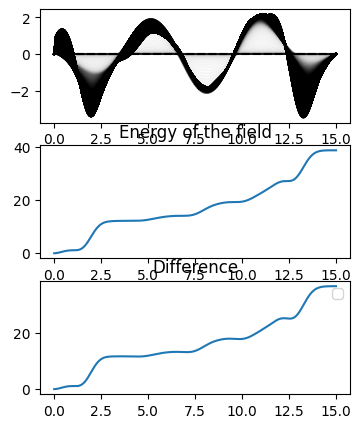

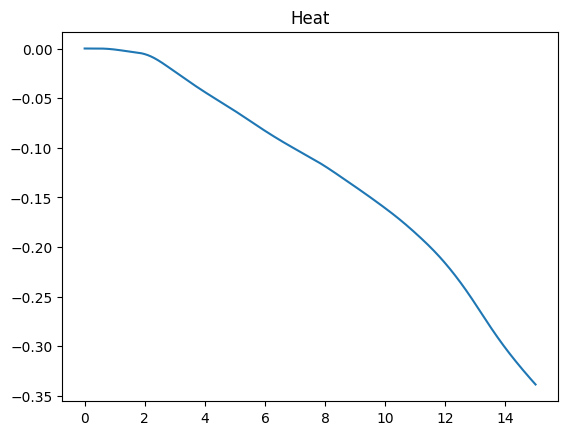

In [23]:

# NBVAL_IGNORE_OUTPUT
# the DensityMatrixODEPropagator is not sufficiently exact to guarantee that
# you won't get slightly different results in the optimization when
# running this on different systems
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options,
    tlist,
    iter_stop=20000,
    propagator=krotov.propagators.DensityMatrixODEPropagator(
        atol=1e-10, rtol=1e-8
    ),
    chi_constructor=chis_qubit,
    info_hook=krotov.info_hooks.chain(
        krotov.info_hooks.print_debug_information, print_qubit_error
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('5e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
     ),
      store_all_pulses=True,
)

plot_iterations(opt_result)


In [24]:
opt_result.states[0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.02734596+0.j         -0.02634811-0.02433602j -0.00664201-0.01055191j
   0.03784397-0.00857639j]
 [-0.02634811+0.02433602j  0.29944003+0.j          0.00282088-0.00529247j
   0.09979785+0.31799584j]
 [-0.00664201+0.01055191j  0.00282088+0.00529247j  0.04963597+0.j
  -0.04283125-0.01106657j]
 [ 0.03784397+0.00857639j  0.09979785-0.31799584j -0.04283125+0.01106657j
   0.62357803+0.j        ]]

In [25]:
def trace_A(rho):
    """Partial trace over the TLS degrees of freedom"""
    rho_q = np.zeros(shape=(2, 2), dtype=np.complex_)
    rho_q[0, 0] = rho[0, 0] + rho[2, 2]
    rho_q[0, 1] = rho[0, 1] + rho[2, 3]
    rho_q[1, 0] = rho[1, 0] + rho[3, 2]
    rho_q[1, 1] = rho[1, 1] + rho[3, 3]
    return qt.Qobj(rho_q)

Giovannetti

In [26]:
def HA_coeff(t, args):
      return  np.exp(-(t*1j*omega))

def HB_coeff(t, args):
      return  np.exp((t*1j*omega))


def hamiltonian(omega, g,F):
    """Liouvillian for the coupled system of qubit and TLS"""
    sminus=qt.Qobj(np.array([[0,1],[0,0]]))
    splus=qt.Qobj(np.array([[0,0],[1,0]]))
    H0_q = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # drive qubit Hamiltonian
    H1_A = F*splus
    H1_B = F*sminus

    # drift TLS Hamiltonian
    H0_T = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))

    # Lift Hamiltonians to joint system operators
    H0 = qutip.tensor(H0_q, qutip.qeye(2)) + qutip.tensor(qutip.qeye(2), H0_T)
    H1A = qutip.tensor(H1_A, qutip.qeye(2))
    H1B = qutip.tensor(H1_B, qutip.qeye(2))
    # qubit-TLS interaction
    H_int =  g*(qutip.tensor(qutip.Qobj(np.array([[0, 0], [1, 0]])),qutip.Qobj(np.array([[0, 1], [0, 0]])))+qutip.tensor(qutip.Qobj(np.array([[0, 1], [0, 0]])),qutip.Qobj(np.array([[0, 0], [1, 0]]))))

    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0 + H_int)
    H1A = qutip.Qobj(H1A)
    H1B = qutip.Qobj(H1B)
    return [H0,[H1A,HA_coeff],[H1B,HB_coeff]]

In [27]:
def eigenvalues(A):
    eigenValues, eigenVectors = npla.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues
    
def eigenvectors(A):
    eigenValues, eigenVectors = npla.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenVectors

/tmp/ipykernel_219/3532739376.py:32: RuntimeWarning: invalid value encountered in double_scalars
  ratio[i]=ergotropy[i]/energy[i]


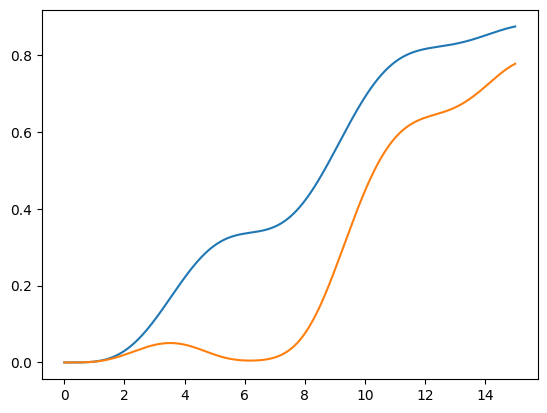

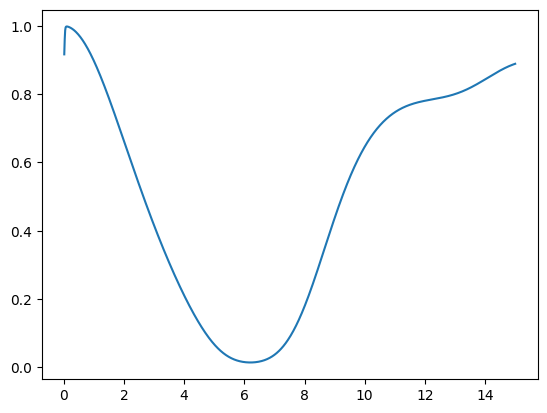

In [28]:
import qutip as qt
import numpy as np
from numpy import linalg as npla
sminus=qt.Qobj(np.array([[0,1],[0,0]]))
splus=qt.Qobj(np.array([[0,0],[1,0]]))
F=0.5
g=0.2
gamma=0.05
omega=1
H=hamiltonian(omega,g,F)
psi0=qt.tensor(qt.basis(2,0),qt.basis(2,0))
T = 15  # final time
nt = 1000
t=np.linspace(0,T,nt)
N=0
H0=omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
output = qt.mesolve(H, psi0, t, [qt.tensor(np.sqrt(gamma*(N+1))*sminus,qt.qeye(2)),qt.tensor(np.sqrt(gamma*N)*splus,qt.qeye(2))], [])
energy=np.zeros(len(t))
ergotropy=np.zeros(len(t))
ratio=np.zeros(len(t))
for i in range (0,len(t)):
  rho_A=output.states[i].ptrace(1)


  rho_f=qt.Qobj(eigenvalues(rho_A)[1]*qt.basis(2,0)*qt.basis(2,0).dag()+eigenvalues(rho_A)[0]*qt.basis(2,1)*qt.basis(2,1).dag())
  #r=np.sqrt(((rho_A*qt.sigmax()).tr())**2+((rho_A*qt.sigmay()).tr())**2+((rho_A*qt.sigmaz()).tr())**2)
  #sminusexp=(rho_A*sminus).tr()
  #splusexp=(rho_A*splus).tr()
  #zexp=(rho_A*qt.sigmaz()).tr()
  energy[i]=np.real((rho_A*H0).tr())
  ergotropy[i]=np.real(((rho_A-rho_f)*H0).tr())
  ratio[i]=ergotropy[i]/energy[i]
plt.plot(t,energy)
plt.plot(t,ergotropy)
plt.figure()
plt.plot(t,ratio)


/tmp/ipykernel_219/568663055.py:22: RuntimeWarning: invalid value encountered in double_scalars
  ratio[i]=Ergotropy[i]/Energy[i]
/tmp/ipykernel_219/568663055.py:40: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(tlist,ergotropy/energy,label="Gio")


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.07698193+0.j         -0.06917936-0.03540259j]
 [-0.06917936+0.03540259j  0.92301807+0.j        ]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.07698193+0.j         -0.06917936-0.03540259j]
 [-0.06917936+0.03540259j  0.92301807+0.j        ]]


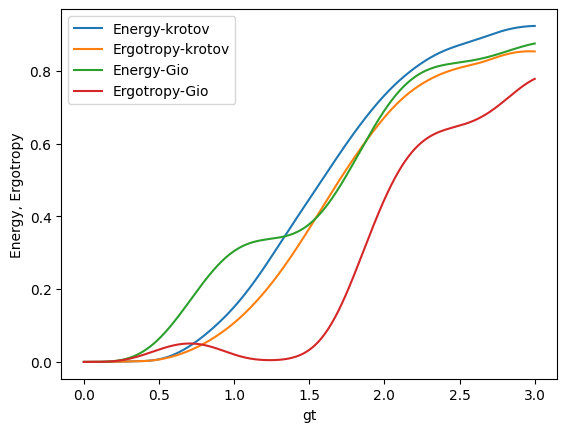

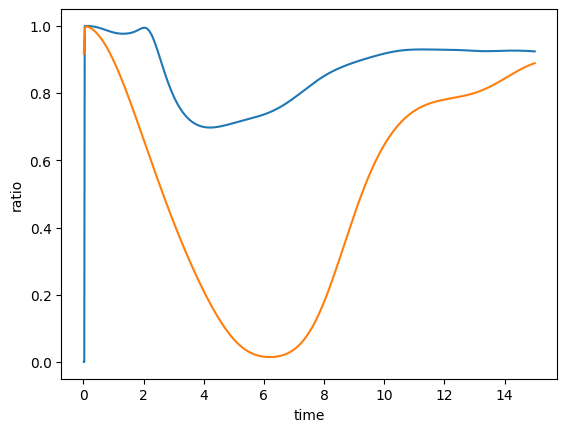

In [29]:
from numpy import linalg as npla

def eigenvalues(A):
    eigenValues, eigenVectors = npla.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues)

optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
      tlist, e_ops=[]
  )
Ergotropy=np.zeros(nt)
Energy=np.zeros(nt)
ratio=np.zeros(nt)

for i in range(0,nt):
  FinalRho=trace_A(np.array(optimized_dynamics.states[i]))
  Rho_f=eigenvalues(FinalRho)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalRho)[0]*np.array([[0, 0], [0, 1]])
  Energy[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalRho)))
  Ergotropy[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_f-FinalRho))))
  ratio[i]=Ergotropy[i]/Energy[i]



plt.plot(g*tlist,Energy,label='Energy-krotov')
plt.plot(g*tlist,Ergotropy,label='Ergotropy-krotov')
plt.plot(g*tlist,energy,label="Energy-Gio")
plt.plot(g*tlist,ergotropy,label="Ergotropy-Gio")



plt.xlabel("gt")
plt.ylabel("Energy, Ergotropy")
plt.legend()  


plt.figure()
plt.plot(tlist,ratio,label="Krotov")
plt.plot(tlist,ergotropy/energy,label="Gio")
plt.xlabel("time")
plt.ylabel("ratio")

#plt.legend()

print(trace_A(opt_result.states[0]))
print(opt_result.states[0].ptrace(1))

In [30]:
T=15
EField=np.transpose(np.array(opt_result.optimized_controls))
EEnergy=np.zeros(len(tlist))
EEnergy[0]=(np.square(EField[0]))*(T/nt)
a=0
for i in range (1,nt):
    a+=np.square(EField[i-1])
    EEnergy[i]=(np.square(EField[i])+a)*(T/nt)

print(EEnergy[nt-1])

38.599059648894034


Giovanneti is 29.012

## Simulate the dynamics of the optimized field

The plot of the optimized field shows that the optimization slightly shifts
the field such that qubit and TLS are no longer perfectly in resonance.

In [31]:
def non_optimized(F,omega,tlist):
    non_opt=np.zeros(len(tlist))
    for i in range(0,len(tlist)):
        non_opt[i]=F*2*np.cos(omega*tlist[i])
    return non_opt

Text(0, 0.5, '$\\epsilon(t)$')

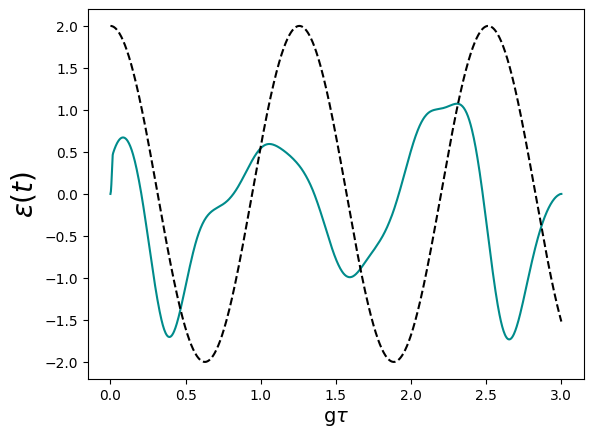

In [39]:
plt.plot(g*tlist,opt_result.optimized_controls[0]/2,color='darkcyan')
plt.plot(g*tlist,non_optimized(2,1,tlist)/2,color='black', linestyle='dashed')
plt.xlabel(r'g$\tau$',fontsize=14)
plt.ylabel(r'$\epsilon(t)$',fontsize=20)

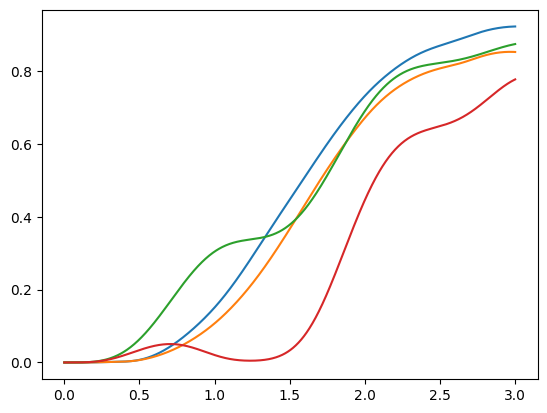

In [40]:
plt.plot(g*tlist,Energy,label='Energy-krotov')
plt.plot(g*tlist,Ergotropy,label='Ergotropy-krotov')
plt.plot(g*tlist,energy,label="Energy-Gio")
plt.plot(g*tlist,ergotropy,label="Ergotropy-Gio")

In [42]:
(Ergotropy[-1]/ergotropy[-1] -1 )*100

9.68063219981168

In [35]:
Ergotropy[-1]

0.8529447534252362

In [36]:
ergotropy[-1]

0.7776621417274259

This slight shift of qubit and TLS out of resonance delays the population
oscillations between qubit and TLS ground state such that the qubit ground
state is maximally populated at final time $T$.

In [37]:
print(Energy[nt-1])
print(Ergotropy[nt-1])
print(Ergotropy[nt-1]/Energy[nt-1])

0.9230326601829565
0.8529447534252362
0.9240677932849873


In [38]:
beta=100000
H0_q = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # drive qubit Hamiltonian


    # drift TLS Hamiltonian
H0_T = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))

    # Lift Hamiltonians to joint system operators
H0 = np.kron(H0_q, np.identity(2)) + np.kron(np.identity(2), H0_T)


    # qubit-TLS interaction
H_int =  g*(np.kron(np.array([[0, 0], [1, 0]]),np.array([[0, 1], [0, 0]]))+np.kron(np.array([[0, 1], [0, 0]]),np.array([[0, 0], [1, 0]])))

    # convert Hamiltonians to QuTiP objects
H0 = qutip.Qobj(H0 + H_int)


    # Define Lindblad operators
N = 1.0 / (np.exp(beta * omega) - 1.0)
    # Cooling on TLS
L1 = np.sqrt(gamma * (N + 1)) * np.kron(np.array([[0, 1], [0, 0]]),np.identity(2))
    # Heating on TLS
L2 = np.sqrt(gamma * N) * np.kron(np.array([[0, 0], [1, 0]]),np.identity(2))
    

    # convert Lindblad operators to QuTiP objects
L1 = qutip.Qobj(L1)
L2 = qutip.Qobj(L2)

    # generate the Liouvillian




Int1=0
Int2=0
DeltaT=T/nt
for i in range (0,nt):
  rho=np.array(optimized_dynamics.states[i])
  EField=np.transpose(np.array(opt_result.optimized_controls))
  H1_q = -0.5*qutip.operators.sigmax()*EField[i,0]
  H1 = qutip.Qobj(np.kron(H1_q, qutip.qeye(2)))
  L0 = (qutip.superoperator.liouvillian(H0+H1, c_ops=[L1, L2])).dag()
  L = qutip.superoperator.liouvillian(H0+H1, c_ops=[L1, L2])(optimized_dynamics.states[i])
  HS=np.real(np.sqrt(np.trace(np.array(L.dag()*L))))
  Int1+=1/T*(T/nt)*HS
  Int2+=1/T*(T/nt)*np.sqrt(np.trace(np.array(L0(optimized_dynamics.states[0])**2)))

F=np.real(np.sqrt(np.trace(np.dot(np.array(optimized_dynamics.states[nt-1]),np.array(optimized_dynamics.states[0])))))
L=np.arccos(F)
numerator=4*(L**2)
denominator=Int2*(math.pi)*(math.pi)
Tau2=np.real(numerator/denominator)
Tau1=np.sin(L)**2/Int1
print(Tau1)
print(Tau2)
print(T)
print(T-Tau2)

/tmp/ipykernel_219/590552913.py:21: RuntimeWarning: overflow encountered in exp
  N = 1.0 / (np.exp(beta * omega) - 1.0)


TypeError: Incompatible Qobj shapes

In [ ]:
def HA_coeff(t, args):
      return  np.exp(-(t*1j*omega))

def HB_coeff(t, args):
      return  np.exp((t*1j*omega))


def hamiltonian(omega, g,F):
    """Liouvillian for the coupled system of qubit and TLS"""
    sminus=qt.Qobj(np.array([[0,1],[0,0]]))
    splus=qt.Qobj(np.array([[0,0],[1,0]]))
    H0_q = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # drive qubit Hamiltonian
    H1_A = F*splus
    H1_B = F*sminus

    # drift TLS Hamiltonian
    H0_T = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # Lift Hamiltonians to joint system operators
    H0 = H0_q +  H0_T

    # qubit-TLS interaction
    H_int =  g*(qutip.tensor(sminus,qt.eye(2))*qutip.tensor(qt.qeye(2),splus)+qutip.tensor(splus,qt.qeye(2))*qutip.tensor(qt.qeye(2),sminus) )
    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0 + H_int)
    H1A = qutip.Qobj(H1A)
    H1B = qutip.Qobj(H1B)
    return [H0,[H1A,HA_coeff],[H1B,HB_coeff]]

In [ ]:
sminus=qt.Qobj(np.array([[0,1],[0,0]]))
splus=qt.Qobj(np.array([[0,0],[1,0]]))
F=1
g=0.2
gamma=0.05
omega=1

H=hamiltonian(omega,g,F)
psi0=qt.tensor(qt.basis(2,0),qt.basis(2,0),qt.basis(2,0),qt.basis(2,0),qt.basis(2,0))
T = np.pi/g # final time
nt = 1000
t=np.linspace(0,T,nt)
N=0
H0 = qutip.tensor(omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)), qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)),qutip.qeye(2),qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), qutip.qeye(2),omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)),qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), qutip.qeye(2),qutip.qeye(2),omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)))

output = qt.mesolve(H, psi0, t, [qt.tensor(np.sqrt(gamma*(N+1))*sminus,qt.qeye(2),qt.qeye(2),qt.qeye(2),qt.qeye(2)),qt.tensor(np.sqrt(gamma*N)*splus,qt.qeye(2),qt.qeye(2),qt.qeye(2),qt.qeye(2))], [])
energy=np.zeros(len(t))
ergotropy=np.zeros(len(t))
ratio=np.zeros(len(t))
for i in range (0,len(t)):
  rho_A=output.states[i].ptrace([1,2,3,4])
  FinalStateCell1=np.array(rho_A.ptrace(0))
  FinalStateCell2=np.array(rho_A.ptrace(1))
  

  FinalStateCell3=np.array(rho_A.ptrace(2))
  FinalStateCell4=np.array(rho_A.ptrace(3))
  Rho_fCell1=eigenvalues(FinalStateCell1)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell1)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell2=eigenvalues(FinalStateCell2)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell2)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell3=eigenvalues(FinalStateCell3)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell3)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell4=eigenvalues(FinalStateCell4)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell4)[0]*np.array([[0, 0], [0, 1]])
  #energy[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell4)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell3)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell1)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell2)))
  ergotropy[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell4-FinalStateCell4))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell3-FinalStateCell3))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell1-FinalStateCell1))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell2-FinalStateCell2))))
  energy[i]=np.real((rho_A*H0).tr())

  #rho_f=qt.Qobj(eigenvalues(rho_A)[1]*qt.basis(2,0)*qt.basis(2,0).dag()+eigenvalues(rho_A)[0]*qt.basis(2,1)*qt.basis(2,1).dag())
  #r=np.sqrt(((rho_A*qt.sigmax()).tr())**2+((rho_A*qt.sigmay()).tr())**2+((rho_A*qt.sigmaz()).tr())**2)
  #sminusexp=(rho_A*sminus).tr()
  #splusexp=(rho_A*splus).tr()
  #zexp=(rho_A*qt.sigmaz()).tr()
  #energy[i]=np.real((rho_A*H0).tr())
  #ergotropy[i]=np.real(((rho_A-rho_f)*H0).tr())
  ratio[i]=ergotropy[i]/energy[i]
plt.plot(g*tlist,np.real(Energy),color='darkcyan')
plt.plot(g*tlist,np.real(Ergotropy),ls='dashdot',color='darkcyan')
plt.plot(g*t,np.real(energy),color='black')
plt.plot(g*t,np.real(ergotropy),ls='dashdot',color='black')
plt.xlabel(r'g$\tau$',fontsize=14)
plt.ylabel(r'$\frac{E_{B}}{\omega}$,$\frac{\mathcal{E}_{B}}{\omega}$',fontsize=20)
plt.figure()
plt.plot(g*t,ratio,color='black')
plt.plot(g*t,Ergotropy/Energy,color='darkcyan')
plt.xlabel(r'g$\tau$',fontsize=14)
plt.ylabel(r'$\frac{\mathcal{E}_{B}}{E_B}$',fontsize=20)